## ¿Qué quieres hacer?
- Etiquetar libros (Clasificar).
- Recomendar títulos de libros a través de etiquetas o palabras.
- Hacer agrupaciones de libros por categorías (Agrupar => Clasificar de otra manera).
- Estudiar el sentimiento de los libros.

## 🔍 ¿Para qué sirve el modelo `"sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"`?

Este modelo **convierte textos (frases, párrafos, etc.) en vectores numéricos** llamados *embeddings*. Estos vectores capturan el significado del texto y permiten hacer tareas como:

- Comparar si dos frases significan lo mismo (detección de paráfrasis).
- Buscar textos similares (búsqueda semántica).
- Agrupar frases por tema (clustering).
- Usarlo como input para modelos de ML que necesiten comprensión semántica del texto.

Además, es **multilingüe**, es decir, funciona con muchos idiomas (inglés, español, francés, etc.).

---

## 🛠️ ¿Cómo se usa?

### 1. Instalación de librerías necesarias:

```bash
pip install sentence-transformers
```

### 2. Código básico de uso:

```python
from sentence_transformers import SentenceTransformer

# Cargar el modelo
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Lista de textos a convertir
texts = ["Hola, ¿cómo estás?", "Hello, how are you?", "Estoy muy bien, gracias."]

# Obtener embeddings (vectores numéricos)
embeddings = model.encode(texts)

print(embeddings.shape)  # (3, 384)
```

Cada texto se convierte en un vector de 384 dimensiones que representa su significado.

---

## 🔡 Parámetros de entrada (input)

El modelo toma como **entrada una lista de strings**:

```python
texts = ["Texto 1", "Texto 2", ...]
```

- Puedes pasarle solo **una frase** o **una lista de frases**.
- Los textos pueden estar en **cualquier idioma soportado** (incluye español).

---

## 🎯 Salida (output)

La salida es una **matriz de embeddings**:

```python
[
  [0.1, -0.05, ..., 0.23],  # Embedding del primer texto
  [0.03, 0.12, ..., -0.17], # Embedding del segundo texto
  ...
]
```

Cada texto se convierte en un vector de **384 números** (`float32`), que puedes usar para:

- Comparar similitud entre textos con `cosine_similarity`.
- Entrenar modelos de clasificación o clustering.
- Visualización en 2D (reduciendo dimensiones con PCA o t-SNE).

---

## 🧠 Casos de uso reales

| Caso | Entrada | Uso del output |
|------|---------|----------------|
| Detección de duplicados | 2 frases | Comparas los vectores con *cosine similarity* |
| Búsqueda semántica | Texto y base de datos de textos | Vectorizas todo y buscas el más cercano |
| Clasificación | Texto + etiquetas | Vectorizas y entrenas un modelo ML clásico |
| Clustering | Lista de textos | Agrupas los vectores con KMeans o similares |

In [26]:
# %pip install sentence_transformers
# %pip install fastapi
# %pip install uvicorn
# %pip install scikit-learn
# %pip install joblib
# %pip install wordcloud
# %pip install termcolor

In [27]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputClassifier
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc as sklearn_auc  # renombramos por seguridad
import numpy as np
import joblib
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from termcolor import colored
import warnings

# Descargar stopwords de nltk si no están disponibles
# nltk.download('stopwords')

# Combinar stopwords de nltk con otras posibles palabras irrelevantes
my_stop_words = {'to-read', 'closed', 'abandoned-books'
'rating-top', 'literature', 'not-interested', 'libricos', 'recommended',
'000-next', 
'001-ladder-top', '002-ladder-short-term', '003-ladder-medium-term', '004-ladder-long-term', 
'005-ladder-maybe-someday', 
'_cristina', '_giorgia', '_natalia', '_nieves', '_pilar', '_sindy', '_víctor', 'chełmińska'
}
stop_words = set(my_stop_words)
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(stopwords.words('spanish')))
stop_words = stop_words.union(set(stopwords.words('french')))
stop_words = stop_words.union(set(stopwords.words('italian')))

# 1. Cargar el dataset
df = pd.read_csv('../data/processed/books.csv')

In [28]:
# 2. Combinar título y blurb como entrada textual para el modelo
df['text'] = df['book_title'].fillna('') + '. ' + df['blurb'].fillna('')

In [29]:
# 3. Procesar los tags: convertirlos en listas y filtrar stop-words
def filter_stopwords(tags):
    """
    Filtra las stop-words de una lista de etiquetas.
    """
    return [tag for tag in tags if tag.lower() not in stop_words]

df['tags'] = df['tags'].apply(lambda x: filter_stopwords([t.strip() for t in str(x).split(',')]))

# Mantener solo los tags con al menos X ejemplos
#MIN_TAG_FREQ = 10
#tag_counts = df['tags'].explode().value_counts()
#valid_tags = tag_counts[tag_counts >= MIN_TAG_FREQ].index.tolist()
#df['tags'] = df['tags'].apply(lambda tags: [tag for tag in tags if tag in valid_tags])

# 4. Binarización multilabel de los tags
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['tags'])

In [30]:
# 5. Generar embeddings con un modelo multilingüe
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
X_embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Cada texto se convierte en un vector de 384 dimensiones que representa su significado.
print(X_embeddings.shape)

# Muestra los 5 primeros embeddings
print(X_embeddings[:5])

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

(1160, 384)
[[ 0.02750626  0.24533911 -0.28562394 ... -0.07536055 -0.11509603
  -0.052958  ]
 [ 0.13428229  0.19359675 -0.12010901 ...  0.17271587 -0.02152544
   0.20994484]
 [-0.08193501  0.13613778 -0.3626985  ... -0.0060622   0.02430391
  -0.10530125]
 [-0.08946097  0.22455171 -0.21121377 ...  0.11752453  0.10014538
   0.09203939]
 [ 0.03017087  0.09743527 -0.2866786  ...  0.05749123  0.04960755
   0.03592228]]


In [31]:
# 6. Entrenar modelo multilabel
clf = MultiOutputClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_embeddings, Y)

# 7. Guardar modelo y objetos necesarios
joblib.dump(clf, '../model/book_tagging_pipeline.joblib')
joblib.dump(mlb, '../model/book_tagging_pipeline_mlb.joblib')
joblib.dump(model, '../model/book_tagging_pipeline_sentence_bert.joblib')

# ...existing code...

# 8. Función para predecir tags de nuevos libros
def predict_tags(titles, blurbs, threshold=0.3, stop_words=None):
    """
    Predice etiquetas para nuevos libros.
    
    Args:
        titles (list): Lista de títulos de libros.
        blurbs (list): Lista de descripciones de libros.
        threshold (float): Umbral para convertir probabilidades en etiquetas binarias.
        stop_words (set): Conjunto de etiquetas que deben ser filtradas.
        
    Returns:
        list: Lista de listas con las etiquetas predichas (sin las stop words).
    """
    if stop_words is None:
        stop_words = set()  # Si no se proporcionan stop words, usar un conjunto vacío.
    
    texts = [t + '. ' + b for t, b in zip(titles, blurbs)]
    X_test = model.encode(texts)
    
    # Obtener las probabilidades de predicción
    preds_proba = np.array([proba[:, 1] for proba in clf.predict_proba(X_test)]).T
    
    # Aplicar el umbral para convertir probabilidades en etiquetas binarias
    preds = (preds_proba >= threshold).astype(int)
    
    # Invertir la binarización para obtener las etiquetas originales
    tag_lists = mlb.inverse_transform(preds)
    
    # Filtrar las etiquetas que están en stop_words
    filtered_tags = [[tag for tag in tags if tag not in stop_words] for tags in tag_lists]
    return filtered_tags

In [32]:
# Ejemplo de predicción de un libro inventado
new_titles = ["La conspiración del universo"]
new_blurbs = ["Una historia que entrelaza ciencia, fe y filosofía para revelar los secretos de la creación."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['astronomy', 'philosophy', 'religion', 'science']]


In [33]:
# Ejemplo generación de embeddings para la "Isla del Tesoro" en inglés
new_titles = ["Treasure Island"]
new_blurbs = ["Treasure Island is an adventure novel by Scottish author Robert Louis Stevenson, narrating a tale of buccaneers and buried gold."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'fiction', 'literary-criticism']]


In [34]:
# Ejemplo generación de embeddings para la "Isla del Tesoro" en español
new_titles = ["La isla del tesoro"]
new_blurbs = ["La isla del tesoro es una novela de aventuras del autor escocés Robert Louis Stevenson, que narra una historia de bucaneros y oro enterrado."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'fiction', 'literary-criticism']]


In [35]:
# Ejemplo generación de embeddings para "El Quijote"
new_titles = ["Don Quijote de la Mancha"]
new_blurbs = ["Don Quijote de la Mancha es una novela escrita por el español Miguel de Cervantes Saavedra. Publicada su primera parte con el título de El ingenioso hidalgo don Quijote de la Mancha a comienzos de 1605, es una de las obras más destacadas de la literatura española y la literatura universal."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'spain']]


In [36]:
# Ejemplo de predicción de etiquetas
new_titles = [
    "Cosmos",
    "Clean Code",
    "True Devotion to Mary",
    "The Divine Comedy",
    "Fear and Trembling",
    "Pride and Prejudice",
    "The Diary of a Young Girl",
    "The History of the Decline and Fall of the Roman Empire",
    "Republic",
    "The Story of Art"
]

new_blurbs = [
    "Carl Sagan’s groundbreaking exploration of the universe, tracing humanity’s quest to understand the cosmos.",
    "Robert C. Martin’s influential guide to writing clean, understandable, and maintainable code.",
    "St. Louis de Montfort’s enduring spiritual classic, reflecting on the profound significance of devotion to the Virgin Mary.",
    "Dante Alighieri’s epic poem traversing Hell, Purgatory, and Heaven, illuminating the depths of human nature and redemption.",
    "Søren Kierkegaard’s seminal work on existential anxiety, faith, and the leap beyond rational understanding.",
    "Jane Austen’s beloved novel about love and social expectations in Georgian England.",
    "Anne Frank’s harrowing yet hopeful personal account of life in hiding during World War II.",
    "Edward Gibbon’s exhaustive chronicle tracing the factors behind the collapse of the Roman Empire.",
    "Plato’s foundational philosophical dialogue exploring justice, society, and the ideal state.",
    "E. H. Gombrich’s accessible survey tracing the evolution of art from prehistoric times to the modern era."
]

predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)

# Print each item in a new line
for tags in predicted_tags:
    print(tags)

['astronomy', 'creation', 'philosophy', 'physics', 'science', 'space']
['programming']
['apparitions', 'biography', 'catholic', 'classics', 'devotional', 'france', 'holiness', 'illustrated', 'nuns', 'saints', 'spirituality', 'virgin-mary', 'women']
['catholic', 'classics', 'medieval', 'poetry', 'spirituality']
['anxiety', 'christianity', 'mental-health', 'miex', 'nonfiction', 'philosophy', 'psichology', 'selfhelp', 'suffering', 'theology']
['apologetics', 'biography', 'classics', 'courtship', 'emotional-relationships', 'essays', 'family', 'fiction', 'history', 'hope', 'love', 'marriage', 'philosophy', 'poetry', 'psichology', 'romance', 'selfhelp', 'virtues', 'women']
['biography', 'classics', 'fiction', 'memoir', 'psichology', 'romance', 'women']
['anti-catholics', 'church-history', 'communism', 'essays', 'history']
['allegories', 'ancient-literature', 'classics', 'greek', 'history', 'philosophy', 'politics', 'virtues', 'women']
['art', 'essays']


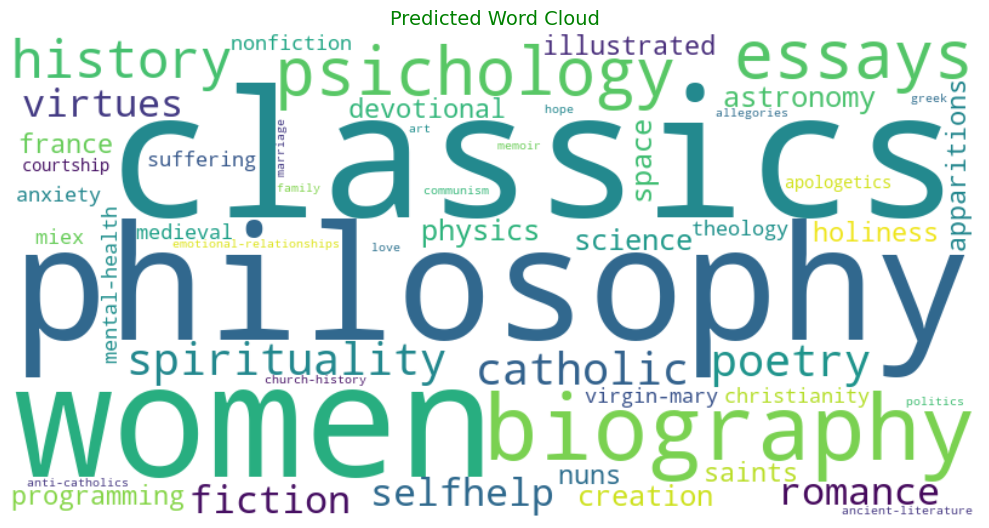

In [37]:
# Contar la frecuencia de las etiquetas
all_tags = [tag for tags in predicted_tags for tag in tags]
tag_counts = Counter(all_tags)

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tag_counts)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Predicted Word Cloud", fontsize=14, color='green')
plt.tight_layout()
plt.savefig('../img/tag_wordcloud.jpg')
plt.show()

In [38]:
# 9. Dividir el dataset en entrenamiento (80%) y evaluación (20%)
df_train, df_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.2, random_state=42)

# Verificar etiquetas en Y_train
valid_labels = np.any(Y_train, axis=0) & np.any(~Y_train, axis=0)  # Etiquetas con al menos un 0 y un 1
Y_train = Y_train[:, valid_labels]  # Filtrar etiquetas problemáticas
Y_test = Y_test[:, valid_labels]    # Ajustar también el conjunto de prueba
mlb.classes_ = mlb.classes_[valid_labels]  # Actualizar las clases del binarizador


# Reentrenar el modelo con el conjunto de entrenamiento
X_train_embeddings = model.encode(df_train['text'].tolist(), show_progress_bar=True)
clf.fit(X_train_embeddings, Y_train)

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [39]:
# 10. Evaluar el modelo con el conjunto de prueba
X_test_embeddings = model.encode(df_test['text'].tolist(), show_progress_bar=True)
Y_pred = clf.predict(X_test_embeddings)

# Calcular el score y el % de aciertos
print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Classification Report:
                             precision    recall  f1-score   support

               16th-century       0.00      0.00      0.00         0
               18th-century       0.00      0.00      0.00         0
               19th-century       0.00      0.00      0.00         0
               20th-century       0.00      0.00      0.00         1
         abandonment-in-god       0.00      0.00      0.00         2
                   abortion       0.00      0.00      0.00         0
                 acceptance       0.00      0.00      0.00         1
           action-adventure       0.00      0.00      0.00         0
                adolescence       0.00      0.00      0.00         3
                     adults       0.00      0.00      0.00         0
                     advent       0.00      0.00      0.00         0
                 adventures       0.00      0.00      0.00         8
                     africa       0.00      0.00      0.00         4
      afte

In [40]:
# 11. Comparar predicciones con los tags reales y colorear resultados
def compare_predictions(real_tags, predicted_tags):
    """
    Compara las etiquetas reales con las predichas y las colorea.
    """
    result = []
    for real, predicted in zip(real_tags, predicted_tags):
        comparison = []
        for tag in real:
            if tag in predicted:
                comparison.append(colored(tag, 'green'))  # Acertado
            else:
                comparison.append(colored(tag, 'red'))  # No acertado
        result.append(comparison)
    return result

# Obtener las etiquetas reales y predichas
real_tags = df_test['tags'].tolist()
predicted_tags = predict_tags(df_test['book_title'].tolist(), df_test['blurb'].tolist(), stop_words=stop_words)

# Comparar y mostrar resultados coloreados
colored_results = compare_predictions(real_tags, predicted_tags)
for i, (real, predicted, colored_tags) in enumerate(zip(real_tags, predicted_tags, colored_results)):
    print(f"\nLibro {i + 1}:")
    print(f"Título: {df_test.iloc[i]['book_title']}")
    print(f"Etiquetas reales: {real}")
    print(f"Etiquetas predichas: {predicted}")
    print(f"Comparación coloreada: {', '.join(colored_tags)}")


Libro 1:
Título: Discernment: Reading the Signs of Daily Life
Etiquetas reales: ['catholic', 'spirituality', 'theology']
Etiquetas predichas: ['catholic', 'theology']
Comparación coloreada: catholic, spirituality, theology

Libro 2:
Título: Envoy for Christ: 25 Years as a Catholic Apologist
Etiquetas reales: []
Etiquetas predichas: ['catholic', 'christ', 'conversions', 'devotional', 'prayer']
Comparación coloreada: 

Libro 3:
Título: The Resurrection: Experience Life in the Risen Christ
Etiquetas reales: ['catholic', 'christ', 'lent', 'resurrection', 'testimonies']
Etiquetas predichas: ['catholic', 'spirituality', 'theology']
Comparación coloreada: catholic, christ, lent, resurrection, testimonies

Libro 4:
Título: The Dogma of Purgatory
Etiquetas reales: ['biography', 'catholic', 'church-history', 'dogmas', 'faith', 'illustrated', 'nonfiction', 'purgatory', 'religion', 'saints', 'sobrenatural', 'spirituality', 'suffering', 'testimonies', 'theology', 'visions']
Etiquetas predichas: ['

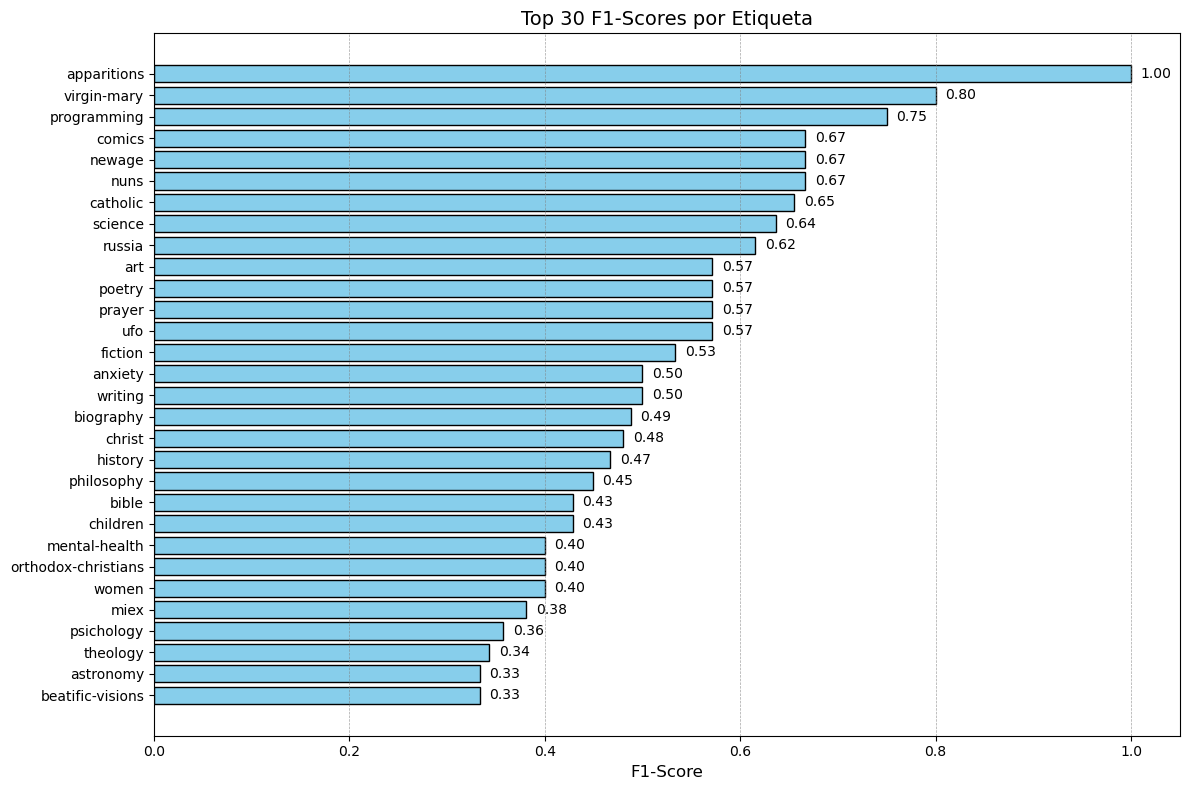

In [41]:
# Ignorar los warnings de métricas indefinidas
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

limit_tags = 30

# Gráfica con las etiquetas con un mejor f1-score
f1_scores = []
for i, tag in enumerate(mlb.classes_):
    report = classification_report(Y_test[:, i], Y_pred[:, i], output_dict=True, zero_division=0)
    # Check if the key '1' exists in the report
    if '1' in report:
        f1 = report['1']['f1-score']
    else:
        f1 = 0.0  # Default value if class '1' is not present
    f1_scores.append((tag, f1))

# Ordenar las etiquetas por F1-score en orden descendente y tomar las 20 primeras
f1_scores = sorted(f1_scores, key=lambda x: x[1], reverse=True)[:limit_tags]
tags, scores = zip(*f1_scores)

# Crear la carpeta si no existe
output_dir = '../img'
os.makedirs(output_dir, exist_ok=True)

# Crear la gráfica
plt.figure(figsize=(12, 8))
bars = plt.barh(tags, scores, color='skyblue', edgecolor='black')

# Añadir divisiones grises claras
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Añadir etiquetas con los valores al final de cada barra
for bar, score in zip(bars, scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{score:.2f}', va='center', fontsize=10, color='black')

# Configurar etiquetas y título
plt.xlabel('F1-Score', fontsize=12)
plt.title(f'Top {limit_tags} F1-Scores por Etiqueta', fontsize=14)
plt.gca().invert_yaxis()  # Invertir el eje Y para que el mayor F1-score esté arriba

# Guardar la gráfica
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'f1_score_per_tag.jpg'))

# save the stop-30 scores in a csv file
f1_scores_df = pd.DataFrame(f1_scores, columns=['Tag', 'F1-Score'])
f1_scores_df.to_csv(os.path.join('../data/processed', 'f1_scores.csv'), index=False)

plt.show()

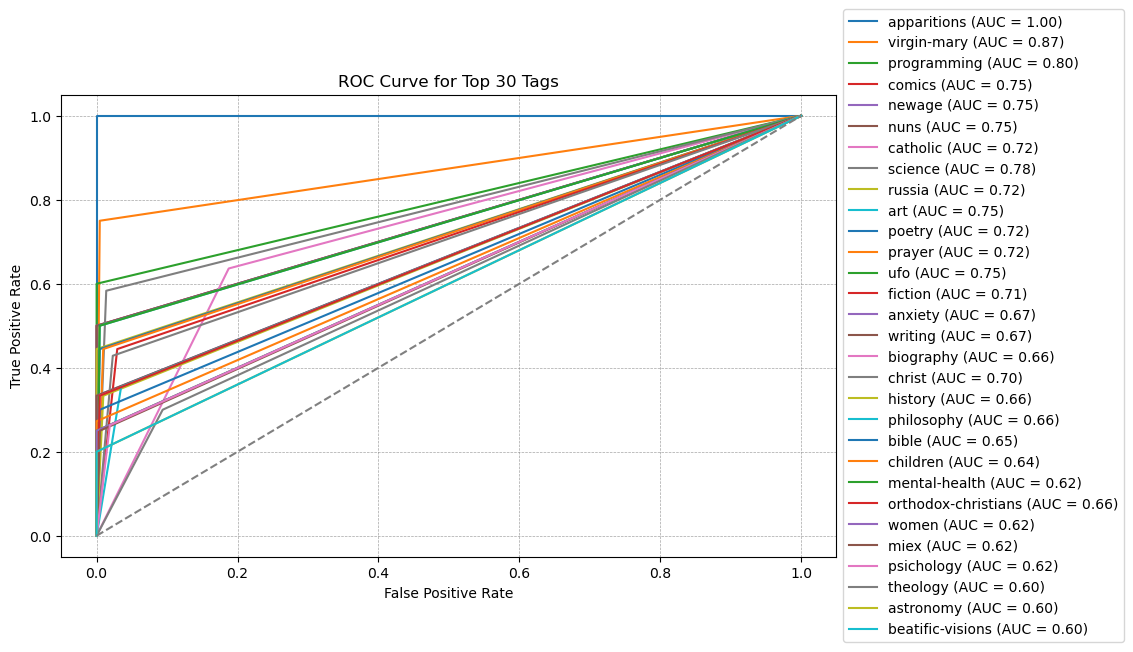

In [42]:
# Mostrar ROC AUC para las 30 etiquetas con mejor F1-score

# Crear la carpeta si no existe
os.makedirs(output_dir, exist_ok=True)

# Crear la gráfica
plt.figure(figsize=(10, 6))
for tag in tags:
    i = np.where(mlb.classes_ == tag)[0][0]
    fpr, tpr, _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    auc = roc_auc_score(Y_test[:, i], Y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{tag} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Top {limit_tags} Tags')
# Grid with a gray color dash line
plt.grid(linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
# Put the legend on the left side of the graph
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Guardar la gráfica
plt.savefig(os.path.join(output_dir, 'roc_curve_per_tag.jpg'))
plt.show()

## Curva ROC por etiqueta (Top-N)

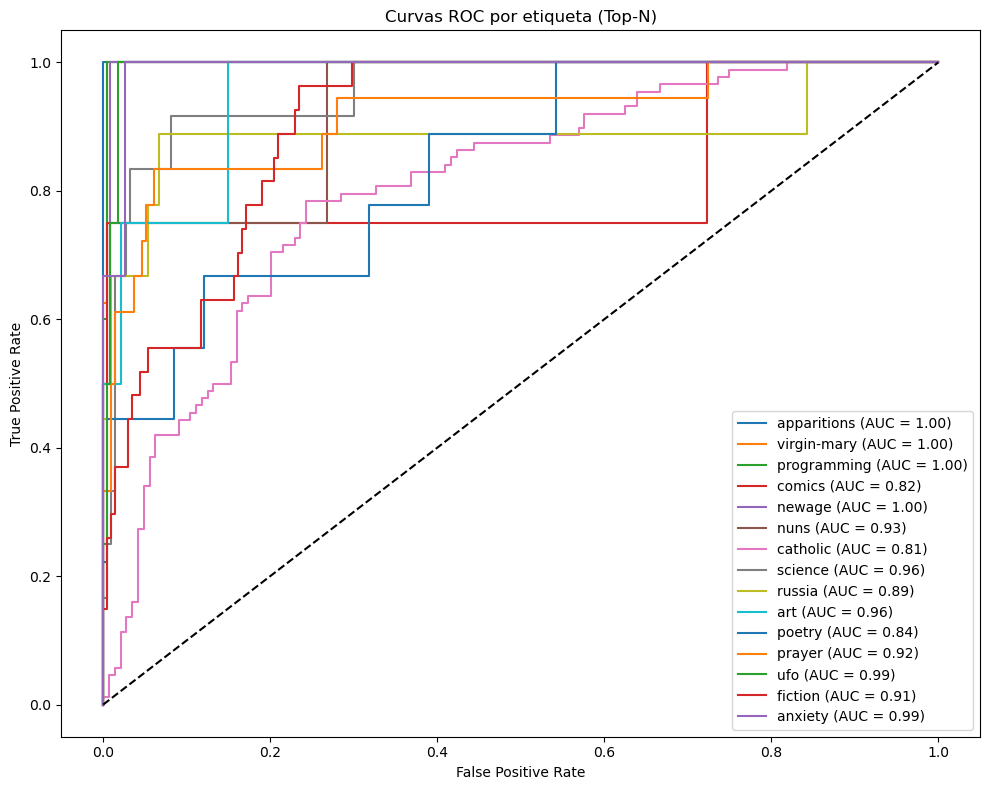

In [43]:
top_n = 15  # Cambia según necesidad
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(top_n):
    tag = tags[i]
    y_true = Y_test[:, mlb.classes_.tolist().index(tag)]
    y_score = clf.predict_proba(X_test_embeddings)[mlb.classes_.tolist().index(tag)][:, 1]
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = sklearn_auc(fpr, tpr)
    
    ax.plot(fpr, tpr, label=f'{tag} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Curvas ROC por etiqueta (Top-N)')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_curves_top_tags.jpg'))
plt.show()


## Matriz de Confusión Multilabel simplificada

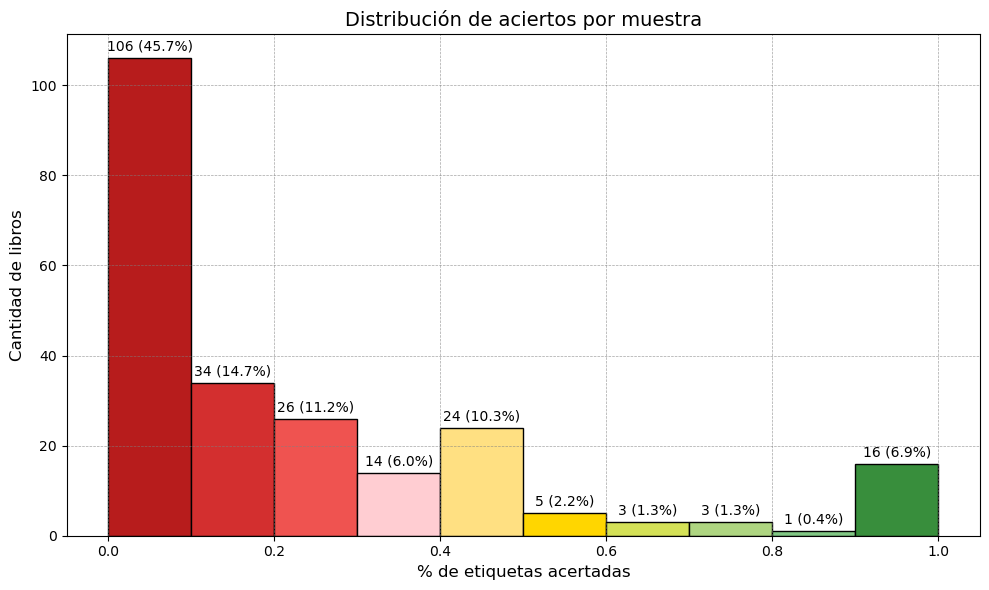

Recuento de libros por intervalo de aciertos:
  0.0 - 0.1 : 106 (45.7%) libros
  0.1 - 0.2 : 34 (14.7%) libros
  0.2 - 0.3 : 26 (11.2%) libros
  0.3 - 0.4 : 14 (6.0%) libros
  0.4 - 0.5 : 24 (10.3%) libros
  0.5 - 0.6 : 5 (2.2%) libros
  0.6 - 0.7 : 3 (1.3%) libros
  0.7 - 0.8 : 3 (1.3%) libros
  0.8 - 0.9 : 1 (0.4%) libros
  0.9 - 1.0 : 16 (6.9%) libros


In [44]:
# Simulación de datos para ejemplo (elimina si ya tienes Y_pred y Y_test)
# Y_pred = np.random.randint(0, 2, size=(1000, 5))
# Y_test = np.random.randint(0, 2, size=(1000, 5))

# Cálculo de precisión por muestra
correct_counts = np.sum((Y_pred == Y_test) & (Y_test == 1), axis=1)
total_relevant = np.sum(Y_test, axis=1)
accuracy_per_sample = correct_counts / (total_relevant + 1e-10)

fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(accuracy_per_sample, bins=10, edgecolor='black')

# Total de libros
total_samples = len(accuracy_per_sample)

# Definir gradiente manual de colores de rojo a verde
gradient_colors = [
    "#b71c1c",  # rojo muy oscuro
    "#d32f2f",  # rojo oscuro
    "#ef5350",  # rojo claro
    "#ffcdd2",  # salmón claro
    "#ffe082",  # amarillo pastel
    "#ffd600",  # amarillo vivo
    "#d4e157",  # verde lima
    "#aed581",  # verde medio
    "#81c784",  # verde claro
    "#388e3c"   # verde fuerte
]

# Aplicar color según la posición del bin
for i, patch in enumerate(patches):
    color = gradient_colors[i % len(gradient_colors)]
    patch.set_facecolor(color)

# Grid en ambos ejes
ax.grid(axis='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Etiquetas sobre cada barra: número + porcentaje
for i in range(len(patches)):
    height = n[i]
    if height > 0:
        percent = (height / total_samples) * 100
        ax.text(patches[i].get_x() + patches[i].get_width() / 2,
                height + 1,
                f'{int(height)} ({percent:.1f}%)',
                ha='center', va='bottom', fontsize=10, color='black')

# Títulos y etiquetas
ax.set_title('Distribución de aciertos por muestra', fontsize=14)
ax.set_xlabel('% de etiquetas acertadas', fontsize=12)
ax.set_ylabel('Cantidad de libros', fontsize=12)
plt.tight_layout()

# Guardar figura
plt.savefig(os.path.join(output_dir, 'accuracy_per_sample_hist.jpg'))

# Guardar tabla como CSV
hist_data = pd.DataFrame({
    'Interval': [f"{bins[i]:.1f} - {bins[i+1]:.1f}" for i in range(len(n))],
    'Count': n,
    'Percentage': (n / total_samples) * 100
})
hist_data.to_csv(os.path.join('../data/processed', 'accuracy_histogram.csv'), index=False)

plt.show()

# Mostrar en consola
print("Recuento de libros por intervalo de aciertos:")
for i in range(len(n)):
    low = bins[i]
    high = bins[i+1]
    count = int(n[i])
    percent = (count / total_samples) * 100
    print(f"  {low:.1f} - {high:.1f} : {count} ({percent:.1f}%) libros")


### 🎯 ¿Cuántas etiquetas acertó el modelo por libro?

Analizamos qué porcentaje de etiquetas reales fue correctamente predicho para cada libro del conjunto de prueba. A continuación, se muestra la distribución:

| Intervalo de aciertos | Libros en ese rango       |
|------------------------|----------------------------|
| 0% - 10%               | 106 (45.7%) libros         |
| 10% - 20%              | 34 (14.7%) libros          |
| 20% - 30%              | 26 (11.2%) libros          |
| 30% - 40%              | 14 (6.0%) libros           |
| 40% - 50%              | 24 (10.3%) libros          |
| 50% - 60%              | 5 (2.2%) libros            |
| 60% - 70%              | 3 (1.3%) libros            |
| 70% - 80%              | 3 (1.3%) libros            |
| 80% - 90%              | 1 (0.4%) libros            |
| 90% - 100%             | 16 (6.9%) libros           |

---

### 📌 Conclusiones clave

- 🔻 Casi la mitad de los libros (**45.7%**) tuvieron menos del **10%** de sus etiquetas reales correctamente predichas.
- 🎯 Solo un pequeño grupo (**6.9%**) fue etiquetado **casi perfectamente** (más del 90% de acierto).
- 🟣 Un porcentaje intermedio de libros (aprox. **28.2%**) recibió entre un **20% y 50%** de etiquetas acertadas, lo que sugiere que el modelo está parcialmente captando el contenido en muchos casos.

---

### 🧠 ¿Qué nos dice esto?

- El modelo **funciona bien en algunos casos**, pero **tiende a ser conservador**, dejando muchas etiquetas sin asignar.
- Este tipo de comportamiento es **típico en tareas multilabel**, especialmente si hay **desbalance de clases** o si las etiquetas tienen **significados sutiles o solapados**.
- Hay oportunidades claras para mejorar:
  - Ajustar el umbral de predicción.
  - Entrenar con más datos.
  - Trabajar con estrategias de balanceo o ponderación.

## Precision-Recall por etiqueta (Top-N)

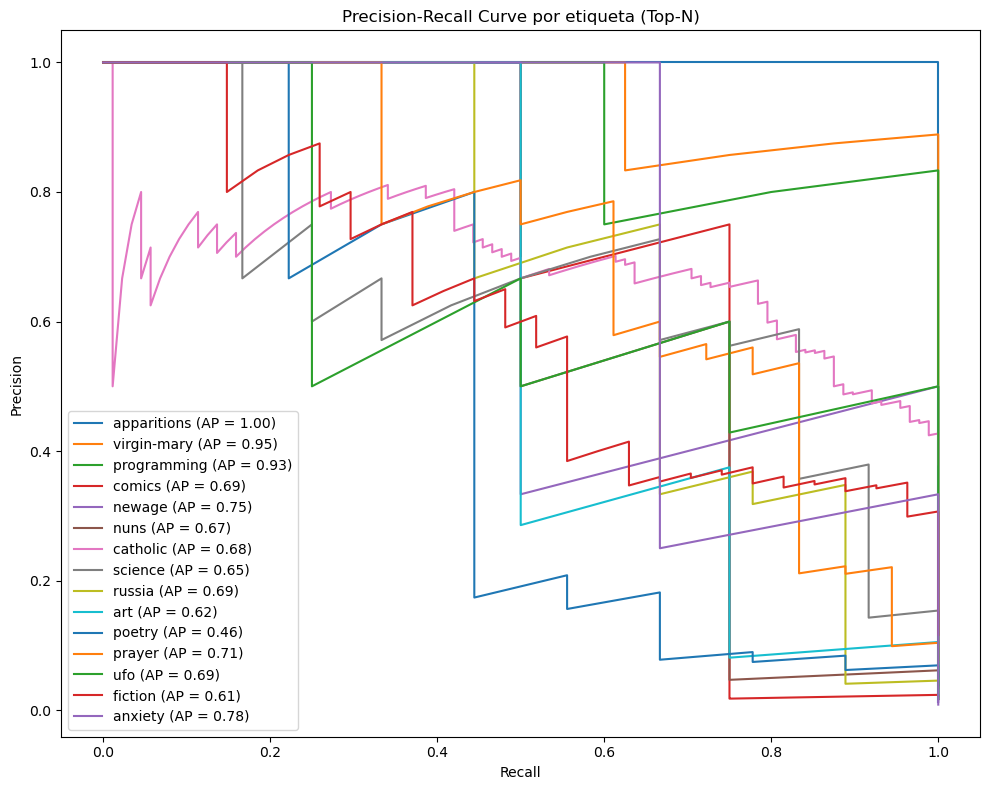

In [45]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, ax = plt.subplots(figsize=(10, 8))

for i in range(top_n):
    tag = tags[i]
    y_true = Y_test[:, mlb.classes_.tolist().index(tag)]
    y_score = clf.predict_proba(X_test_embeddings)[mlb.classes_.tolist().index(tag)][:, 1]
    
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    avg_precision = average_precision_score(y_true, y_score)
    
    ax.plot(recall, precision, label=f'{tag} (AP = {avg_precision:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve por etiqueta (Top-N)')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'precision_recall_curves.jpg'))
plt.show()


## Cobertura de etiquetas reales vs predichas

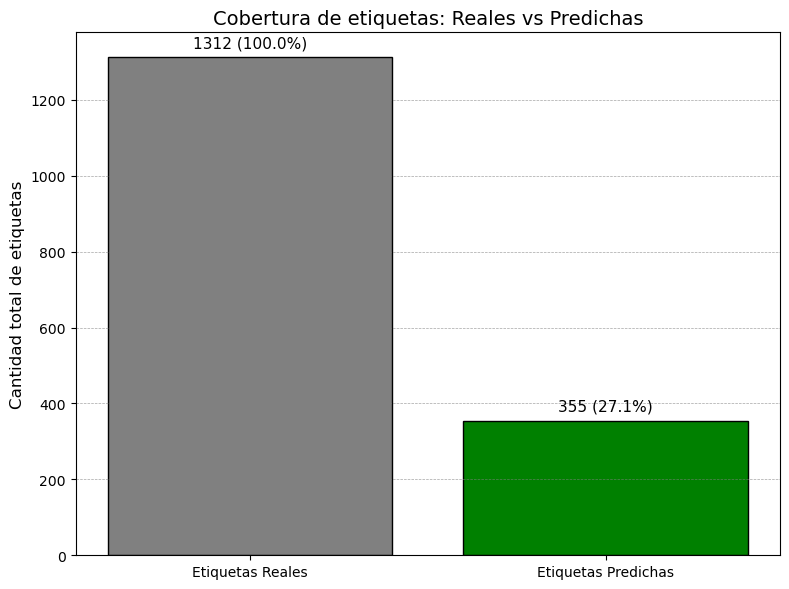

In [46]:
# Gráfico comparando cobertura de etiquetas reales vs predichas
true_tag_count = np.sum(Y_test)
pred_tag_count = np.sum(Y_pred)

labels = ['Etiquetas Reales', 'Etiquetas Predichas']
counts = [true_tag_count, pred_tag_count]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['gray', 'green'], edgecolor='black')

# Añadir líneas de grid horizontales
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Etiquetas con porcentaje sobre cada barra
total = max(counts)
for bar, count in zip(bars, counts):
    percent = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.02,
             f'{count:.0f} ({percent:.1f}%)', ha='center', fontsize=11)

plt.title('Cobertura de etiquetas: Reales vs Predichas', fontsize=14)
plt.ylabel('Cantidad total de etiquetas', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'label_coverage_comparison.jpg'))

# Save this data to a CSV file
coverage_data = pd.DataFrame({'Label Type': labels, 'Count': counts})
coverage_data.to_csv(os.path.join('../data/processed', 'label_coverage.csv'), index=False)

plt.show()

### 📊 Cobertura de Etiquetas: ¿Cuánto predijo bien el modelo?

- En el conjunto de prueba (20% de los libros), había un total de **1312 etiquetas reales**.
- El modelo logró predecir correctamente **355 etiquetas**, lo que representa un **27.1%** del total.

---

### ✅ ¿Qué significa esto?

- El modelo **está captando parte del significado de los textos**, pero **todavía deja muchas etiquetas sin predecir**.
- Esto **no es necesariamente malo** en multilabel: es común que un modelo sea **conservador** para evitar errores.
- **Mejorando el umbral**, los datos o el modelo podríamos aumentar esta cobertura.

---

### 🧠 ¿Y ahora qué?

- Analizar etiquetas frecuentes que nunca se predicen (¿quizás faltan ejemplos de ellas?).
- Evaluar si el **umbral de 0.3** es demasiado alto o bajo para este caso.
- Podríamos usar un modelo más complejo, más datos, o técnicas como **data augmentation** o **re-balanceo de clases**.

## Cross Validation

In [47]:
# %%
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import shutil

# Recalcular binarizador para tener todas las clases actualizadas y sincronizadas
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['tags'])  # Recalcula Y con todas las clases
mlb_classes = mlb.classes_         # Guardamos esto para usar en cada fold

# Generar embeddings (ya se generaron antes, pero aseguramos que están)
# (Puedes comentar esta línea si ya has generado antes `X_embeddings`)
# X_embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
all_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_embeddings)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train_fold = X_embeddings[train_index]
    Y_train_fold = Y[train_index]
    X_val_fold = X_embeddings[val_index]
    Y_val_fold = Y[val_index]

    # Verificar etiquetas válidas en el fold
    valid_labels = np.any(Y_train_fold, axis=0) & np.any(~Y_train_fold, axis=0)
    Y_train_fold = Y_train_fold[:, valid_labels]
    Y_val_fold = Y_val_fold[:, valid_labels]
    fold_classes = mlb_classes[valid_labels]

    # Entrenamiento
    clf_fold = MultiOutputClassifier(LogisticRegression(max_iter=1000))
    clf_fold.fit(X_train_fold, Y_train_fold)

    # Evaluación
    Y_pred_fold = clf_fold.predict(X_val_fold)
    f1 = f1_score(Y_val_fold, Y_pred_fold, average='micro')
    all_f1_scores.append(f1)
    print(f"F1 micro: {f1:.4f}")

    # Guardar modelo y etiquetas
    fold_model_dir = f"../model/cv_fold_{fold+1}"
    # os.makedirs(fold_model_dir, exist_ok=True)
    # joblib.dump(clf_fold, os.path.join(fold_model_dir, "model.joblib"))
    # joblib.dump(valid_labels, os.path.join(fold_model_dir, "valid_labels.joblib"))
    # joblib.dump(fold_classes, os.path.join(fold_model_dir, "classes.joblib"))

# Promedio del rendimiento
avg_f1 = np.mean(all_f1_scores)
print(f"\n✅ F1 promedio (micro) tras {n_splits} folds: {avg_f1:.4f}")



--- Fold 1/5 ---
F1 micro: 0.2555

--- Fold 2/5 ---
F1 micro: 0.2308

--- Fold 3/5 ---
F1 micro: 0.2306

--- Fold 4/5 ---
F1 micro: 0.2515

--- Fold 5/5 ---
F1 micro: 0.2451

✅ F1 promedio (micro) tras 5 folds: 0.2427


## 🧠 ¿Qué estamos viendo?

- El **cross-validation** con `KFold` dio un **F1-micro promedio de `0.2427`**.
- En el split simple del **80/20**, el `classification_report` indica un **F1-micro de `0.26` (aprox.)**, tanto en el `micro avg` como en `samples avg`.

---

## 🤔 ¿Qué significa esto?

### 🔎 Sobre el F1-micro:
- El F1-micro **tiene en cuenta todas las etiquetas por igual** y **se enfoca en el total de aciertos frente a errores**.
- Va de **0 a 1**, y **cuanto más alto, mejor**.

---

### 📉 ¿Ha mejorado el modelo con cross-validation?

**No realmente.**
- El resultado de `cross-validation` fue *ligeramente inferior* a tu split original.
- Esto **no significa que el modelo sea peor**, sino que el **cross-validation te está mostrando una evaluación más robusta y realista**.
- Es común que el F1 en un solo split (como el 80/20) dé un valor **optimista**, mientras que `k-fold` da una media más honesta, al probar distintos cortes de los datos.

---

## 💡 ¿Qué puede estar pasando?

1. **Desbalance severo de etiquetas**:
   - Muchas etiquetas tienen *muy pocos ejemplos* (1, 2, 3 muestras). Esto hace que el modelo no aprenda bien sobre ellas.
   - Esto lo confirma el `support = 0` o `1` en muchas clases del `classification_report`.

2. **Etiquetas poco frecuentes no generalizan**:
   - En cada fold, algunas etiquetas quedan **sin ningún ejemplo** en entrenamiento.
   - Esto impide que se puedan predecir correctamente y **afecta el F1 global**.

3. **Multilabel + pocos datos por etiqueta = difícil**:
   - Este problema es típico en multilabel con muchos posibles valores y baja frecuencia por clase.

---

## ✅ Conclusiones

| Aspecto                          | Valoración                          |
|----------------------------------|--------------------------------------|
| ¿El F1 micro ha subido?          | ❌ No, ha bajado un poco             |
| ¿El modelo es ahora más robusto? | ✅ Sí, porque se probó en varios splits |
| ¿Deberías usar cross-validation? | ✅ Totalmente, aunque sea más lento  |
| ¿Necesitas mejorar algo más?     | ✅ Sí, el dataset y el balanceado de etiquetas |

---

## 🔧 Próximos pasos recomendados

1. **Filtrar etiquetas con muy bajo support (<5 muestras)**.
2. **Agrupar etiquetas similares** si algunas son redundantes.
3. **Aumentar los datos** (más libros, más etiquetas).
4. **Balancear las clases** con técnicas como:
   - Oversampling (SMOTE multilabel)
   - Ponderación de clases en `LogisticRegression(class_weight='balanced')`
5. **Ajustar el umbral de predicción** dinámicamente en función del recall/precision.

In [48]:
# %%
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

# Paso 1: Filtrar etiquetas poco frecuentes (menos de 5 apariciones en total)
min_freq = 5
tag_counts = pd.Series(df['tags'].explode()).value_counts()
valid_tags = tag_counts[tag_counts >= min_freq].index.tolist()

df['filtered_tags'] = df['tags'].apply(lambda tags: [tag for tag in tags if tag in valid_tags])

# Paso 2: Recalcular multilabel binarización con solo etiquetas válidas
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['filtered_tags'])
mlb_classes = mlb.classes_

# Paso 3: Regenerar los embeddings si no los tienes
# (Puedes comentar si ya los tienes)
# X_embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Paso 4: K-Fold con mejoras
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
all_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_embeddings)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train_fold = X_embeddings[train_index]
    Y_train_fold = Y[train_index]
    X_val_fold = X_embeddings[val_index]
    Y_val_fold = Y[val_index]

    # Verificar etiquetas válidas por fold
    valid_labels = np.any(Y_train_fold, axis=0) & np.any(~Y_train_fold, axis=0)
    Y_train_fold = Y_train_fold[:, valid_labels]
    Y_val_fold = Y_val_fold[:, valid_labels]
    fold_classes = mlb_classes[valid_labels]

    # Paso 5: Clasificador con balanceo de clases
    base_clfs = []
    for i in range(Y_train_fold.shape[1]):
        y_i = Y_train_fold[:, i]
        classes = np.unique(y_i)
        if len(classes) == 1:
            base_clfs.append(LogisticRegression(max_iter=1000))
        else:
            weights = compute_class_weight('balanced', classes=classes, y=y_i)
            class_weight_dict = dict(zip(classes, weights))
            base_clfs.append(LogisticRegression(max_iter=1000, class_weight=class_weight_dict))

    clf_fold = MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000), n_jobs=-1)
    clf_fold.estimators_ = base_clfs
    clf_fold.fit(X_train_fold, Y_train_fold)

    # Evaluación
    Y_pred_fold = clf_fold.predict(X_val_fold)
    f1 = f1_score(Y_val_fold, Y_pred_fold, average='micro')
    all_f1_scores.append(f1)
    print(f"F1 micro: {f1:.4f}")

    # Guardar modelo del fold
    # fold_model_dir = f"../model/cv_fold_{fold+1}_improved"
    # os.makedirs(fold_model_dir, exist_ok=True)
    # joblib.dump(clf_fold, os.path.join(fold_model_dir, "model.joblib"))
    # joblib.dump(valid_labels, os.path.join(fold_model_dir, "valid_labels.joblib"))
    # joblib.dump(fold_classes, os.path.join(fold_model_dir, "classes.joblib"))

# Resultado global
avg_f1 = np.mean(all_f1_scores)
print(f"\n✅ F1 promedio (micro) mejorado tras {n_splits} folds: {avg_f1:.4f}")

# Guardar el modelo final completo del último fold como referencia general
final_model = clf_fold  # modelo del último fold
final_mlb = MultiLabelBinarizer()
final_mlb.classes_ = fold_classes  # aseguramos que solo incluya las clases válidas del último fold

# Reutiliza el modelo SentenceTransformer ya cargado como `model`
joblib.dump(final_model, '../model/book_tagging_pipeline_cross_validated.joblib')
joblib.dump(final_mlb, '../model/book_tagging_pipeline_mlb_cross_validated.joblib')
joblib.dump(model, '../model/book_tagging_pipeline_sentence_bert_cross_validated.joblib')

print("✅ Nuevo modelo con validación cruzada guardado exitosamente.")



--- Fold 1/5 ---
F1 micro: 0.2683

--- Fold 2/5 ---
F1 micro: 0.2431

--- Fold 3/5 ---
F1 micro: 0.2406

--- Fold 4/5 ---
F1 micro: 0.2664

--- Fold 5/5 ---
F1 micro: 0.2578

✅ F1 promedio (micro) mejorado tras 5 folds: 0.2552
✅ Nuevo modelo con validación cruzada guardado exitosamente.
